In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [25]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=3319b1890da59e3ed61bb178c2521e3af17a1ca5f4eda1e4f96d06b62a867539
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [26]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
# GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/UTKFace.zip", 'r')
# zip_ref = zipfile.ZipFile("UTKFace3.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [5]:
# labels - age, gender, ethnicity
data_dir = './UTKFace'
images = []
age_labels = []
gender_labels = []
race_labels = []

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        # Split the filename
        parts = filename.split('_')
        if len(parts) != 4:
            # Skip files that don't have all four expected parts
            continue
        age, gender, race, _ = parts
        try:
            age = float(age)
            gender = int(gender)
            race = int(race)
        except ValueError:
            # Skip files with non-numeric labels
            continue
        # Add image path and corresponding labels to lists
        image_path = os.path.join(data_dir, filename)
        images.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)
                
# Verify the updated data
print("Total images:", len(images))
print("Total age labels:", len(age_labels))
print("Total gender labels:", len(gender_labels))
print("Total race labels:", len(race_labels))

Total images: 23165
Total age labels: 23165
Total gender labels: 23165
Total race labels: 23165


In [6]:
# convert to dataframe

import pandas as pd
df = pd.DataFrame()
# df['image'], df['age'], df['gender'] = images, age_labels, gender_labels
df['image'], df['age'] = images, age_labels
df.head()

,image,age
0,./UTKFace/36_1_3_20170119202208549.jpg.chip.jpg,36.0
1,./UTKFace/24_1_4_20170103223907208.jpg.chip.jpg,24.0
2,./UTKFace/21_0_1_20170116204921756.jpg.chip.jpg,21.0
3,./UTKFace/29_0_1_20170116011143078.jpg.chip.jpg,29.0
4,./UTKFace/10_1_0_20170109204148144.jpg.chip.jpg,10.0


In [7]:
df

,image,age
0,./UTKFace/36_1_3_20170119202208549.jpg.chip.jpg,36.0
1,./UTKFace/24_1_4_20170103223907208.jpg.chip.jpg,24.0
2,./UTKFace/21_0_1_20170116204921756.jpg.chip.jpg,21.0
3,./UTKFace/29_0_1_20170116011143078.jpg.chip.jpg,29.0
4,./UTKFace/10_1_0_20170109204148144.jpg.chip.jpg,10.0
...,...,...
23160,./UTKFace/28_0_1_20170113134056728.jpg.chip.jpg,28.0
23161,./UTKFace/26_1_1_20170116162111804.jpg.chip.jpg,26.0
23162,./UTKFace/50_0_1_20170117003124915.jpg.chip.jpg,50.0
23163,./UTKFace/30_1_4_20170117193820102.jpg.chip.jpg,30.0


<Figure size 700x600 with 0 Axes>

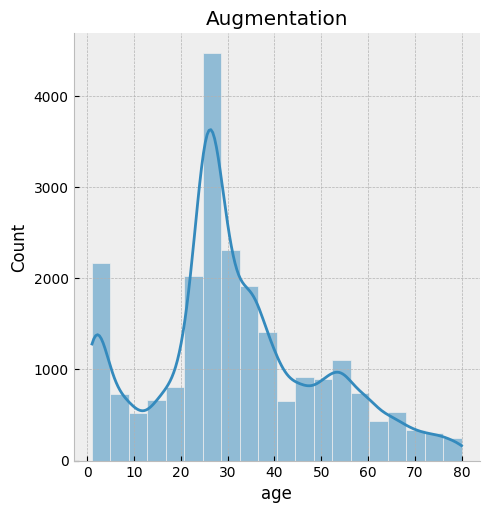

In [8]:
# Set the size of the figure
plt.style.use('bmh')
plt.figure(figsize=(7, 6))  # Set the size to 8 inches wide and 6 inches tall

# df = df[df['age'] < 80]
sns.displot(df['age'],kde=True, bins=20)
plt.title('Augmentation')
# Show the plot

plt.show()

In [9]:
df, test_df = train_test_split(df, test_size=0.2, stratify=df['age'])
# df = df.reset_index(drop=True)
print(len(test_df))
print(len(df))

4633
18532


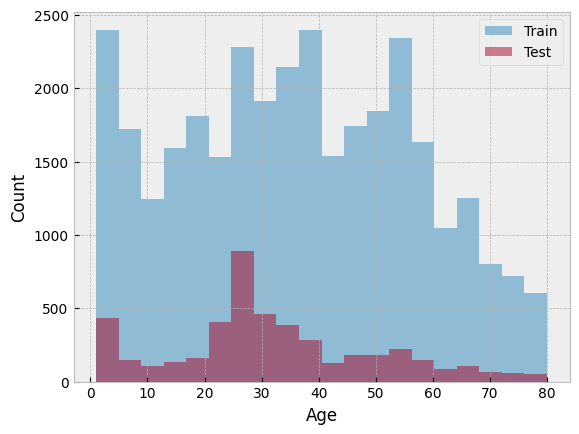

In [13]:
import matplotlib.pyplot as plt

# Plot histogram of age for train and test data
plt.hist(df['age'], bins=20, alpha=0.5, label='Train')
plt.hist(test_df['age'], bins=20, alpha=0.5, label='Test')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()


In [11]:
condition = (df['age'] > 31) | (df['age'] < 21)

# use boolean indexing to filter the rows and duplicate them twice
duplicated_rows = df[condition].copy()
duplicated_twice = pd.concat([duplicated_rows, duplicated_rows])

# concatenate the original dataframe and the duplicated rows twice
df = pd.concat([df, duplicated_twice], ignore_index=True)

df.head()

,image,age
0,./UTKFace/24_1_4_20170117150626732.jpg.chip.jpg,24.0
1,./UTKFace/60_0_0_20170104213241125.jpg.chip.jpg,60.0
2,./UTKFace/30_0_0_20170117171825818.jpg.chip.jpg,30.0
3,./UTKFace/6_0_0_20170110215629811.jpg.chip.jpg,6.0
4,./UTKFace/36_1_4_20170112234015846.jpg.chip.jpg,36.0


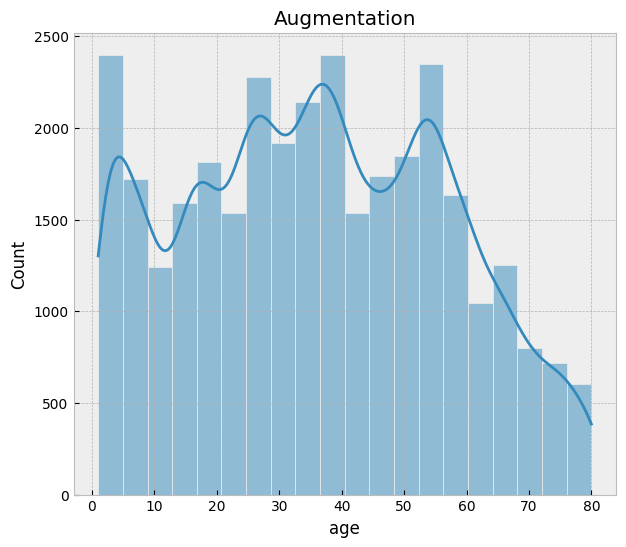

32557
37190


In [12]:

# Count the number of images per age
image_counts = df['age'].value_counts()

cut_off = 600

# Remove images with counts exceeding 280
for age, count in image_counts.items():
    if count > cut_off:
        excess_images = df[df['age'] == age].sample(count - cut_off)
        df = df.drop(excess_images.index)
df = df.reset_index(drop=True)

# Set the size of the figure
plt.style.use('bmh')
plt.figure(figsize=(7, 6))  # Set the size to 8 inches wide and 6 inches tall

# Create the histogram with KDE using seaborn
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Augmentation')
# Show the plot

plt.show()
print(len(df))
print(len(df) + len(test_df))

In [14]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from PIL import ImageEnhance
import torchvision.transforms.functional as TF


# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, index):
#         image_path, age = self.dataframe.iloc[index]
#         image = Image.open(image_path)
#         image = self.transform(image)

#         return image, age

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.age_labels = [i for i in range(80)]
        self.age_intervals = [(i, i+7) for i in range(1, 80, 8)]
        self.age_group_labels = []

        for age in self.dataframe['age']:
            for idx, interval in enumerate(self.age_intervals):
                if interval[0] <= age <= interval[1]:
                    self.age_group_labels.append(idx)
                    break

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path, age = self.dataframe.iloc[index]
        image = Image.open(image_path)
        image = self.transform(image)

        age_group = self.age_group_labels[index]
        age_group = torch.tensor(age_group)

        return image, age_group




train_df, valid_df = train_test_split(df, test_size=0.1, stratify=df['age'])
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


# Define transformations for train, validation, and test sets
transform_train = transforms.Compose([
#      transforms.RandomCrop(180),
    transforms.Resize((224, 224), antialias=True),  # Resize the image with antialiasing
    # transforms.Grayscale(),  # Convert the image to grayscale
    transforms.RandomRotation(10),
#     transforms.Lambda(lambda x: ImageEnhance.Contrast(x).enhance(0.5)),  # Increase contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    # transforms.Grayscale(), 
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = CustomDataset(train_df, transform=transform_train)
valid_dataset = CustomDataset(valid_df, transform=transform_train)
test_dataset = CustomDataset(test_df, transform=transform_test)

# Create data loaders
batch_size = 64

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


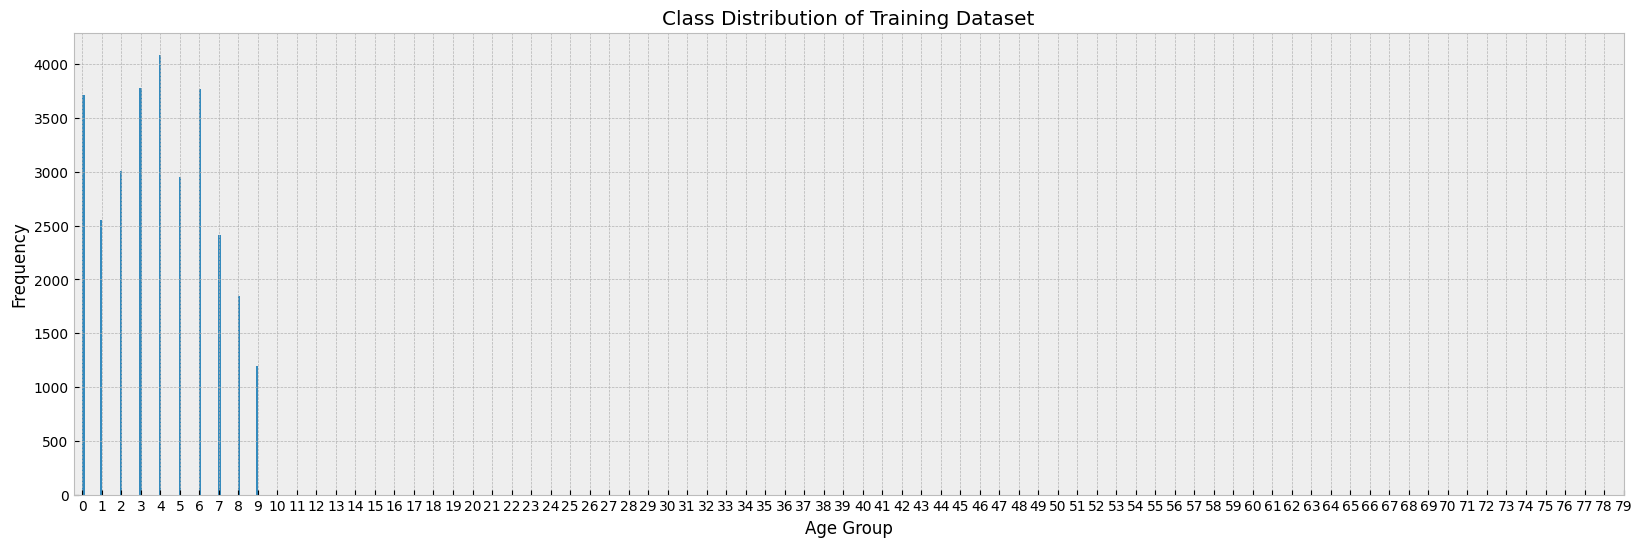

In [18]:
import matplotlib.pyplot as plt

age_groups = train_dataset.age_group_labels
n_bins = len(train_dataset.age_labels)

plt.figure(figsize=(20,6))
plt.hist(age_groups, bins=n_bins)
plt.xticks(range(n_bins), train_dataset.age_labels)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Class Distribution of Training Dataset')
plt.show()


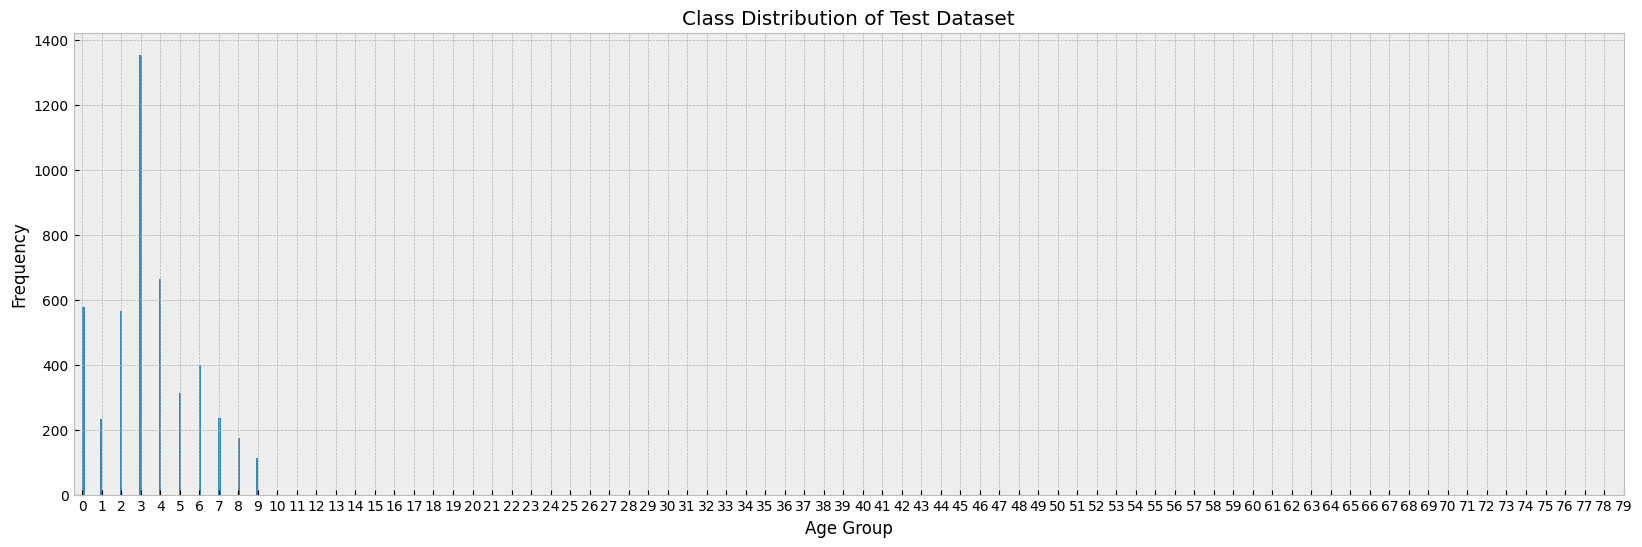

In [19]:
import matplotlib.pyplot as plt

age_groups = test_dataset.age_group_labels
n_bins = len(test_dataset.age_labels)

plt.figure(figsize=(20,6))
plt.hist(age_groups, bins=n_bins)
plt.xticks(range(n_bins), test_dataset.age_labels)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Class Distribution of Test Dataset')
plt.show()


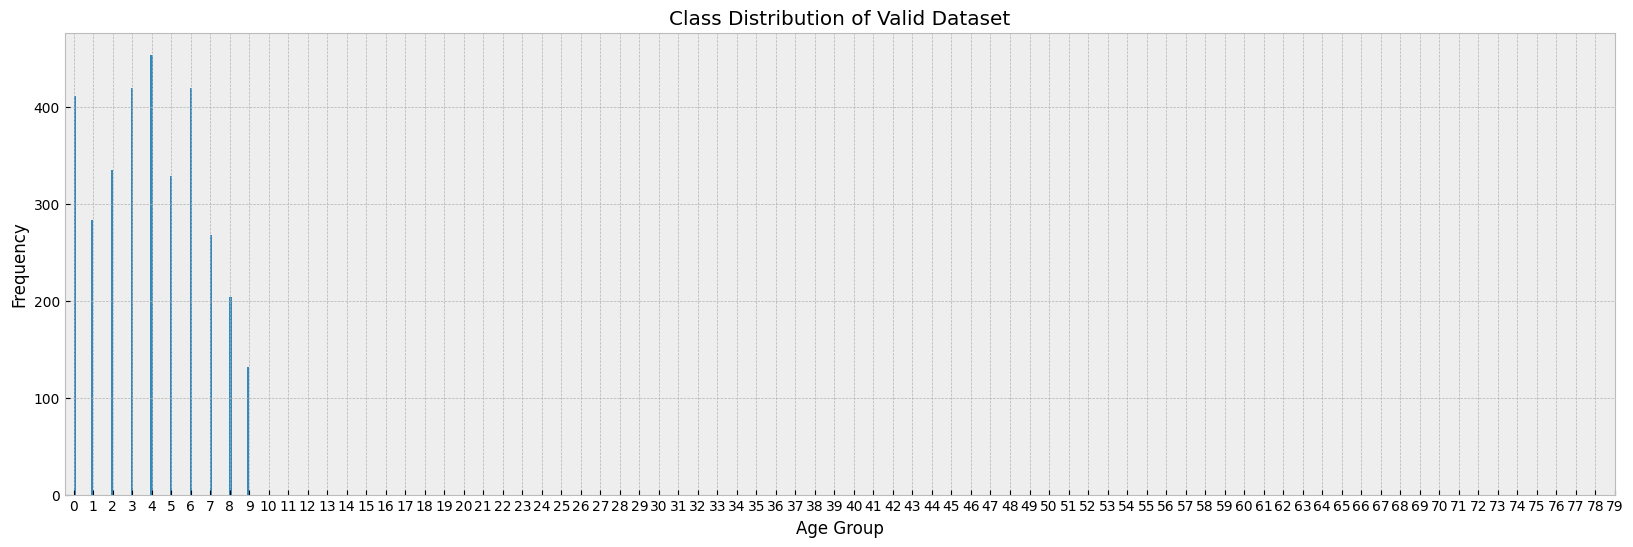

In [20]:
import matplotlib.pyplot as plt

age_groups = valid_dataset.age_group_labels
n_bins = len(valid_dataset.age_labels)

plt.figure(figsize=(20,6))
plt.hist(age_groups, bins=n_bins)
plt.xticks(range(n_bins), valid_dataset.age_labels)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Class Distribution of Valid Dataset')
plt.show()


In [ ]:
# Check the number of channels in the train loader
sample_batch = next(iter(train_loader))
sample_images, _ = sample_batch  # Assuming the images are in the first element of each batch

# Check the shape of the sample image
print(sample_images.shape)  # The shape will be in the format: (batch_size, channels, height, width)

num_channels = sample_images.shape[1]
print(f"Number of channels: {num_channels}")


sample_batch = next(iter(train_loader))
sample_images, _ = sample_batch

# Check the minimum and maximum pixel values in the sample images
min_value = sample_images.min().item()
max_value = sample_images.max().item()

print(f"Minimum pixel value: {min_value}")
print(f"Maximum pixel value: {max_value}")
print(len(train_loader)*batch_size)


torch.Size([32, 1, 128, 128])
Number of channels: 1
Minimum pixel value: 0.0
Maximum pixel value: 1.0
40416


## vgg16

In [31]:
model = models.vgg16(pretrained=True)

In [32]:
# 모델의 마지막 층을 새로운 Fully Connected layer로 대체합니다.
n_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(n_features, 80)
model = model.to(device)

In [ ]:
# # Load the pre-trained VGG16 model
# model = models.vgg16(pretrained=True)

# # Freeze all the layers except the last one
# for param in model.parameters():
#     param.requires_grad = True
# model.classifier[-1] = nn.Linear(4096, 4)
# model = model.to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 수정된 레이어와 새로운 레이어를 함께 fine-tuning합니다.
# learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# criterion = nn.CrossEntropyLoss()


history_dense = {'accuracy': [], 'val_accuracy': []}

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # inputs = inputs.permute(0, 3, 1, 2)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0 or (i + 1) == len(val_loader):
            acc = 100 * correct / total
            correct_val = 0
            total_val = 0
            val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs.float())
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            val_acc = 100 * correct_val / total_val
            val_loss /= len(val_loader)

            print('[%d, %5d/%d] loss: %.3f accuracy: %.3f val_loss: %.3f val_accuracy: %.3f' %
                  (epoch + 1, i + 1, len(train_loader), running_loss / 100, acc, val_loss, val_acc))
            running_loss = 0.0
            correct = 0
            total = 0

    # save train and validation accuracy for current epoch
    history_dense['accuracy'].append(acc)
    history_dense['val_accuracy'].append(val_acc)

[1,    51/458] loss: 1.914 accuracy: 12.377 val_loss: 2.310 val_accuracy: 13.698
[1,   100/458] loss: 1.127 accuracy: 13.202 val_loss: 2.259 val_accuracy: 13.913
[1,   200/458] loss: 2.195 accuracy: 18.859 val_loss: 2.154 val_accuracy: 21.806
[1,   300/458] loss: 2.030 accuracy: 23.844 val_loss: 2.082 val_accuracy: 20.639
[1,   400/458] loss: 1.871 accuracy: 27.672 val_loss: 1.774 val_accuracy: 29.300
[2,    51/458] loss: 0.891 accuracy: 30.944 val_loss: 1.724 val_accuracy: 31.235
[2,   100/458] loss: 0.846 accuracy: 32.079 val_loss: 1.684 val_accuracy: 33.047
[2,   200/458] loss: 1.697 accuracy: 33.750 val_loss: 1.662 val_accuracy: 33.814
[2,   300/458] loss: 1.673 accuracy: 33.609 val_loss: 1.635 val_accuracy: 35.074
[2,   400/458] loss: 1.643 accuracy: 34.438 val_loss: 1.612 val_accuracy: 36.210
[3,    51/458] loss: 0.817 accuracy: 35.723 val_loss: 1.643 val_accuracy: 35.043
[3,   100/458] loss: 0.790 accuracy: 34.439 val_loss: 1.616 val_accuracy: 35.012
[3,   200/458] loss: 1.577 a

In [24]:
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print('Test Accuracy: %.3f %%' % (test_acc))

Test Accuracy: 44.334 %


## wandb

In [ ]:
wandb.init(project='report-me592-vgg16-80')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history_dense = {'accuracy': [], 'val_accuracy': [], 'train_loss': [], 'val_loss': [],  'test_accuracy': []}

for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0 or (i + 1) == len(val_loader):
            acc = 100 * correct / total
            correct_val = 0
            total_val = 0
            val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs.float())
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            val_acc = 100 * correct_val / total_val
            val_loss /= len(val_loader)

            print('[%d, %5d/%d] loss: %.3f accuracy: %.3f val_loss: %.3f val_accuracy: %.3f' %
                  (epoch + 1, i + 1, len(train_loader), running_loss / 100, acc, val_loss, val_acc))
            running_loss = 0.0
            correct = 0
            total = 0

    # # save train and validation accuracy for current epoch
    # history_dense['accuracy'].append(acc)
    # history_dense['val_accuracy'].append(val_acc)
    # history_dense['train_loss'].append(loss.item())
    # history_dense['val_loss'].append(val_loss)
    
    # # log metrics to WandB
    # wandb.log({'train_loss': loss.item(), 'train_accuracy': acc, 'val_loss': val_loss, 'val_accuracy': val_acc})


    # calculate test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model(inputs.float())
    
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_acc = 100 * correct_test / total_test
    print('Test accuracy: %.3f' % (test_acc))
    
    # save train, validation, and test accuracy for current epoch
    history_dense['accuracy'].append(acc)
    history_dense['val_accuracy'].append(val_acc)
    history_dense['train_loss'].append(loss.item())
    history_dense['val_loss'].append(val_loss)
    history_dense['test_accuracy'].append(test_acc)
    
    # log metrics to WandB
    wandb.log({'train_loss': loss.item(), 'train_accuracy': acc, 'val_loss': val_loss, 'val_accuracy': val_acc, 'test_accuracy': test_acc})


[1,    51/458] loss: 2.969 accuracy: 12.071 val_loss: 2.297 val_accuracy: 14.834
[1,   100/458] loss: 1.101 accuracy: 17.028 val_loss: 2.234 val_accuracy: 16.830
[1,   200/458] loss: 2.191 accuracy: 19.188 val_loss: 2.126 val_accuracy: 22.052
[1,   300/458] loss: 2.022 accuracy: 24.359 val_loss: 1.904 val_accuracy: 26.597
[1,   400/458] loss: 1.849 accuracy: 28.641 val_loss: 1.786 val_accuracy: 30.590
Test accuracy: 33.197
[2,    51/458] loss: 0.895 accuracy: 30.668 val_loss: 1.672 val_accuracy: 34.029
[2,   100/458] loss: 0.832 accuracy: 32.366 val_loss: 1.728 val_accuracy: 32.156
[2,   200/458] loss: 1.665 accuracy: 33.656 val_loss: 1.639 val_accuracy: 33.937
[2,   300/458] loss: 1.659 accuracy: 32.734 val_loss: 1.591 val_accuracy: 36.210
[2,   400/458] loss: 1.613 accuracy: 34.516 val_loss: 1.583 val_accuracy: 35.719
Test accuracy: 41.679
[3,    51/458] loss: 0.790 accuracy: 35.907 val_loss: 1.547 val_accuracy: 36.794
[3,   100/458] loss: 0.763 accuracy: 35.587 val_loss: 1.554 val_a